# Chose 3 different classification techniques

## Read data
There are two relevant files for training:
`data/cardiotocography/CTG-9.csv`
`data/cardiotocography/CTG-3.csv`

CTG-9 contains the classification into 9 different classes, from calm sleep to suspect pattern.

CTG-3 contains the classification into 3 different classes, normal, suspect, pathologic.

Clearly the CTG-3 classification is less fine grained, but also has some different rules. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
ctg_3 = pd.read_csv('data/cardiotocography/CTG-3.csv')
ctg_9 = pd.read_csv('data/cardiotocography/CTG-9.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [3]:
print(ctg_9.describe())

                LB           AC           FM           UC           DL  \
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.000000   
mean    133.303857     0.003170     0.009474     0.004357     0.001885   
std       9.840844     0.003860     0.046670     0.002940     0.002962   
min     106.000000     0.000000     0.000000     0.000000     0.000000   
25%     126.000000     0.000000     0.000000     0.001876     0.000000   
50%     133.000000     0.001630     0.000000     0.004482     0.000000   
75%     140.000000     0.005631     0.002512     0.006525     0.003264   
max     160.000000     0.019284     0.480634     0.014925     0.015385   

                DS           DP         ASTV         MSTV        ALTV  ...  \
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.00000  ...   
mean      0.000004     0.000157    46.990122     1.332785     9.84666  ...   
std       0.000063     0.000580    17.192814     0.883241    18.39688  ...   
min       0.000000   

In [4]:
print(ctg_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
LB          2126 non-null int64
AC          2126 non-null float64
FM          2126 non-null float64
UC          2126 non-null float64
DL          2126 non-null float64
DS          2126 non-null float64
DP          2126 non-null float64
ASTV        2126 non-null int64
MSTV        2126 non-null float64
ALTV        2126 non-null int64
MLTV        2126 non-null float64
Width       2126 non-null int64
Min         2126 non-null int64
Max         2126 non-null int64
Nmax        2126 non-null int64
Nzeros      2126 non-null int64
Mode        2126 non-null int64
Mean        2126 non-null int64
Median      2126 non-null int64
Variance    2126 non-null int64
Tendency    2126 non-null int64
Class       2126 non-null int64
dtypes: float64(8), int64(14)
memory usage: 365.5 KB
None


(array([1655.,    0.,    0.,    0.,    0.,  295.,    0.,    0.,    0.,
         176.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

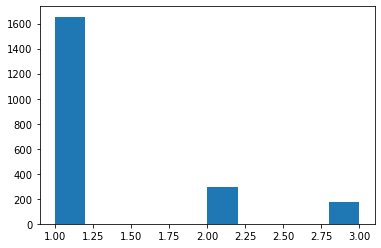

In [5]:
plt.hist(ctg_3['Class'])

(array([384., 579.,  53.,  81.,  72., 332., 252., 107.,  69., 197.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

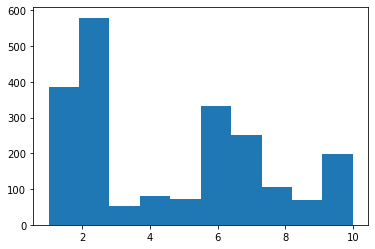

In [6]:
plt.hist(ctg_9['Class'])

## Correlation map

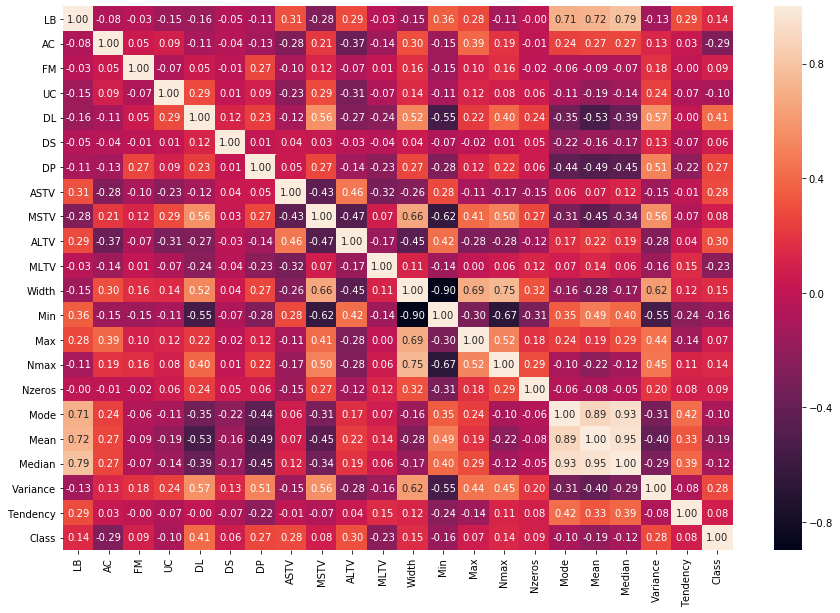

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(ctg_9.corr(),annot=True,fmt='.2f')
plt.show()

## Creating train and test data 
Using a stratified approach to ensure all the classes are in the training data.

In [8]:
X = ctg_3.drop(['Class'], axis = 1).values
y = ctg_3['Class'].values

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [10]:
rus = RandomUnderSampler(random_state = 42)
ros = RandomOverSampler(random_state = 42)
X_under, y_under = rus.fit_sample(X, y)
X_over, y_over = ros.fit_sample(X, y)

In [11]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size = 0.3, random_state = 42, stratify=y_under)
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 42, stratify=y_over)

In [12]:
X_train, X_test, y_train, y_test = X_base_train, X_base_test, y_base_train, y_base_test
#X_train, X_test, y_train, y_test = X_under_train, X_under_test, y_under_train, y_under_test
#X_train, X_test, y_train, y_test = X_over_train, X_over_test, y_over_train, y_over_test


In [13]:
from sklearn.pipeline import Pipeline

# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [81]:
import math
def plot_parameter_analysis(grid, params, param1, param2, params_base, method_name, function_name="accuracy", dataset_name="cardiotocography"):
    scores_df = pd.DataFrame(grid.cv_results_)
    
    #print('params:', params.keys())
    grid_shape = [len(params[param]) for param in params.keys()] 
    scores_mean = [x for x in scores_df['mean_test_score']]
    scores_mean = np.array(scores_mean).reshape(grid_shape)
    scores_std = [x for x in scores_df['std_test_score']]
    scores_std = np.array(scores_std).reshape(grid_shape)
    
    #print('param1', param1)
    #print('param2', param2)
    #print('init', scores_mean.shape, scores_mean)
    for ind, param in enumerate(params.keys()):
        if param is not param1 and param is not param2:
            #print('param', ind,':', param)
            #print('before', scores_mean.shape)#, scores_mean)
            delete_arr = np.array(range(len(params[param])))
            #print ('delete_array', delete_arr)
            delete_arr = delete_arr[[((params[param][p] is not params_base[param][0]) 
                                      if not isinstance(params_base[param][0], float) 
                                         and not isinstance(params[param][p], float)
                                      else math.isclose(params[param][p], params_base[param][0]))
                                     for p in range(len(params[param]))]]
        
            #print ('delete_array', delete_arr)
            scores_mean = np.delete(scores_mean, delete_arr, axis=ind)
            scores_std = np.delete(scores_std, delete_arr, axis=ind)
            #print('after', scores_mean.shape)#, scores_mean)
    scores_mean = np.squeeze(scores_mean)
    scores_std = np.squeeze(scores_std)
    #print('final score shape', scores_mean.shape, scores_mean)
    
    plt.figure(figsize=(20, 20))
    for ind, i in enumerate(params[param2]):
        if list(params.keys()).index(param1) < list(params.keys()).index(param2):
            plt.plot(params[param1], scores_mean[:,ind], label=param2+': ' + str(i))
            plt.plot(params[param1], scores_mean[:,ind] + scores_std[:,ind], color='black', alpha=0.3)
            plt.plot(params[param1], scores_mean[:,ind] - scores_std[:,ind], color='black', alpha=0.3)
        else:
            plt.plot(params[param1], scores_mean[ind], label=param2+': ' + str(i))
            plt.plot(params[param1], scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
            plt.plot(params[param1], scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
    plt.legend()
    plt.xlabel(param1)
    plt.ylabel('Mean score (' + function_name + ')')
    plt.title('Parameter analysis for ' + method_name + "\n" + dataset_name)
    plt.show()

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Logistic Regression
__Score history:__  

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.85 | 0.74, 0.75, 0.74 | 0.86, 0.85, 0.85 |
| with RobustScaler | 0.87 | 0.77, 0.81, 0.78 | 0.89, 0.87, 0.88 |
| - | - | - | - |


### Logistic Regression parameters
TODO

In [15]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix  

c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
pipe_logreg = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression())
])

In [17]:
# create parameter list for ridge regression
params_logreg = {
    'logreg__C':[0.5, 0.6, 0.7, 1.1],
    'logreg__class_weight': [None, 'balanced']
}

In [18]:
# setup cross validation parameter grid search
grid_logreg = GridSearchCV(estimator=pipe_logreg,
    param_grid=params_logreg,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [19]:
# fitting model on training data
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.5s finished
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
        

In [20]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_logreg.best_params_

{'logreg__C': 1.1, 'logreg__class_weight': None}

In [21]:
grid_logreg.score(X_test, y_test) 


0.8855799373040752

In [22]:
y_pred = grid_logreg.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       497
           2       0.61      0.66      0.63        88
           3       0.91      0.74      0.81        53

    accuracy                           0.89       638
   macro avg       0.82      0.78      0.80       638
weighted avg       0.89      0.89      0.89       638



In [24]:
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

[[468  26   3]
 [ 29  58   1]
 [  3  11  39]]


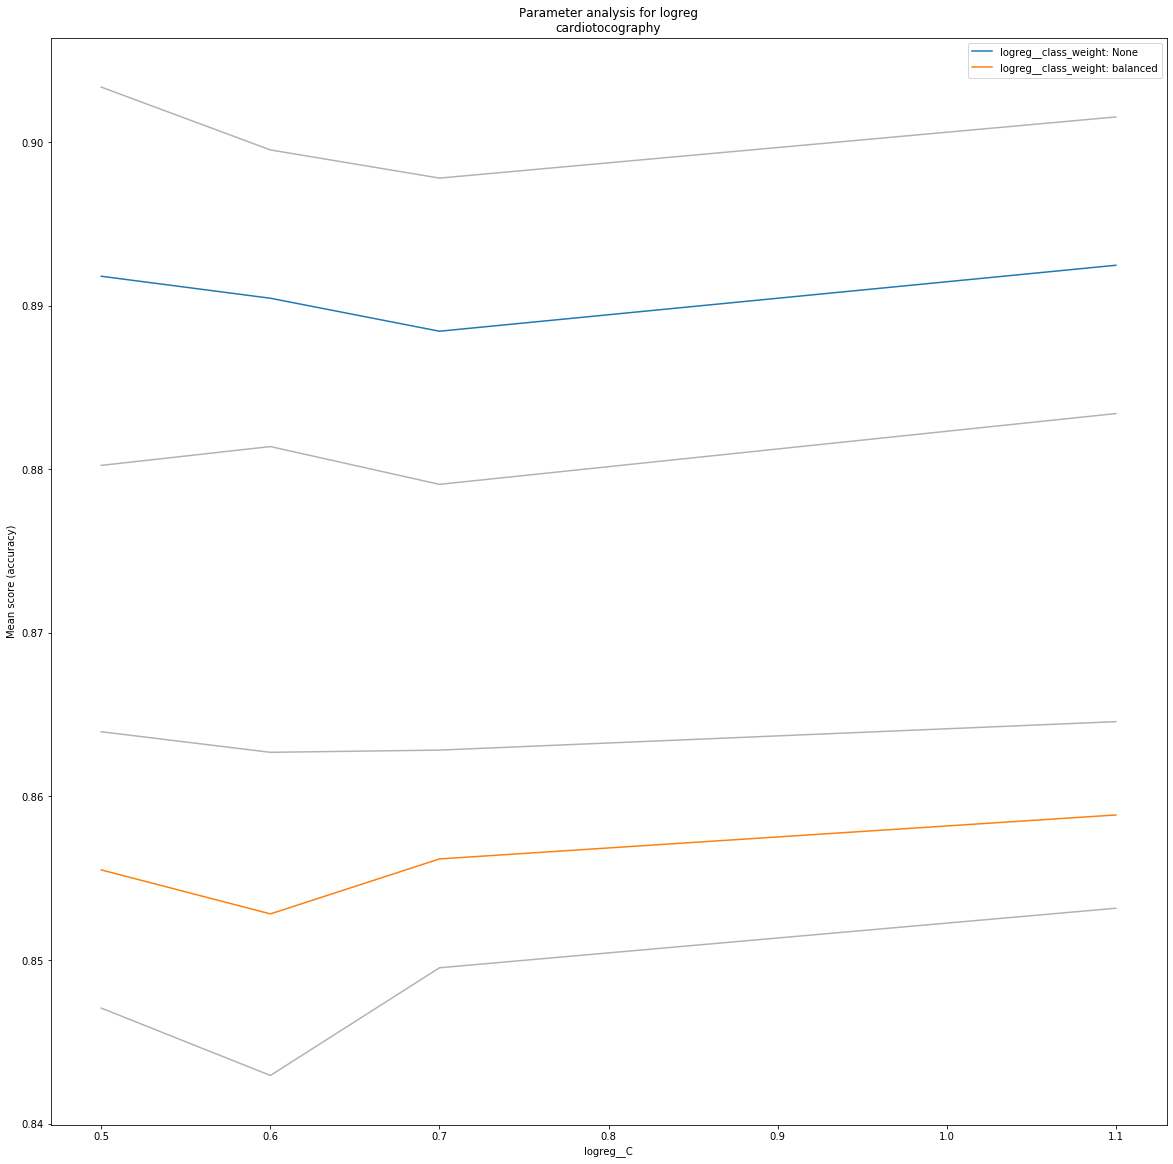

In [92]:
params_logreg_base = {}
plot_parameter_analysis(grid=grid_logreg, params=params_logreg, param1='logreg__C', 
                        param2='logreg__class_weight', params_base=params_logreg_base, 
                        method_name="logreg")

## KNN-Classifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.89 | 0.81, 0.76, 0.78 | 0.89, 0.89, 0.89 |
| without MinMaxScaler | 0.90 | 0.83, 0.77, 0.80 | 0.90, 0.90, 0.90 |
| with RobustScaler | 0.90 | 0.85, 0.79, 0.82 | 0.90, 0.90, 0.90 |
| - | - | - | - |

### KNN Parameters:

In [26]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, RFE

In [27]:
pipe_knn = Pipeline([
    #('scaler', MinMaxScaler()),
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier())
])

In [28]:
params_knn = {
    'knn__n_neighbors': [x for x in range(1,50,2)], 
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance']
}


In [29]:
grid_knn = GridSearchCV(estimator=pipe_knn,
    param_grid=params_knn,
    cv=3,
    #scoring='f1_weighted',
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [30]:
grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighb

In [31]:
grid_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}

In [32]:
grid_knn.score(X_test, y_test) 

0.9012539184952978

In [33]:
y_pred_knn = grid_knn.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           1       0.93      0.96      0.95       497
           2       0.68      0.65      0.66        88
           3       0.95      0.75      0.84        53

    accuracy                           0.90       638
   macro avg       0.85      0.79      0.82       638
weighted avg       0.90      0.90      0.90       638



In [35]:
print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)

[[478  18   1]
 [ 30  57   1]
 [  4   9  40]]


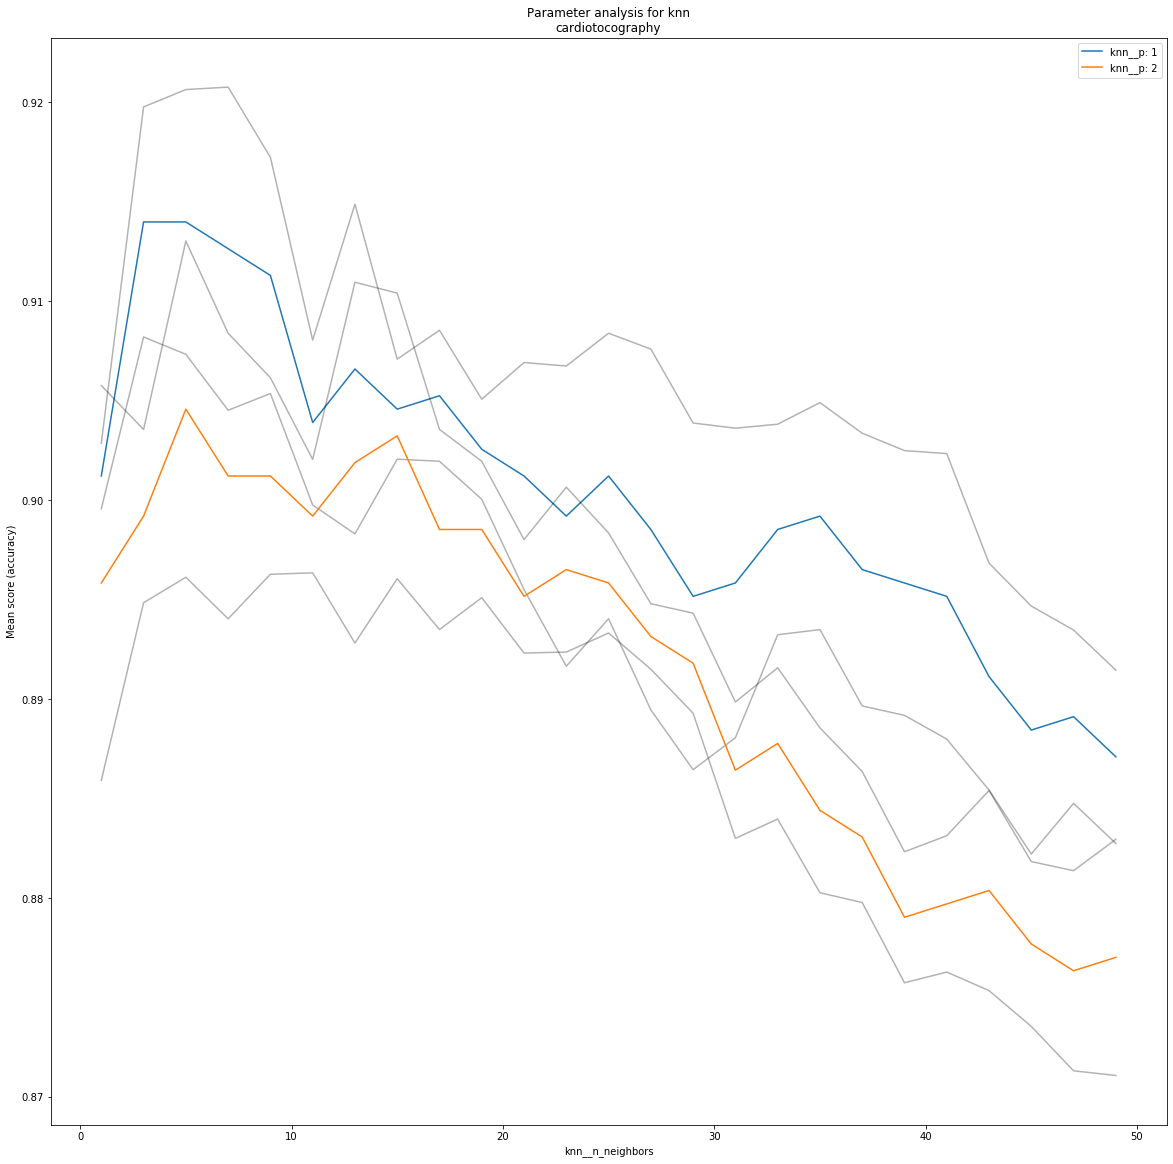

In [36]:
params_knn_base = {
    'knn__weights': ['distance']
}
plot_parameter_analysis(grid=grid_knn, params=params_knn, param1='knn__n_neighbors', 
                        param2='knn__p', params_base=params_knn_base, 
                        method_name="knn")

## Random Forest
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.93 | 0.89, 0.86, 0.87 | 0.92, 0.93, 0.92 |
| - | - | - | - |

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [50]:
pipe_rf = PipelineRFE([
    ('rf', RandomForestClassifier())
])

In [51]:
params_rf = {
    'rf__class_weight': [None, 'balanced'],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__max_leaf_nodes': [None, 5, 6, 7, 8, 9],
    'rf__min_samples_split': [2, 3, 4, 5, 6],
    'rf__n_estimators': [50, 100]
}


In [52]:
grid_rf = GridSearchCV(estimator=pipe_rf,
    param_grid=params_rf,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)


In [53]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=PipelineRFE(memory=None,
                                   steps=[('rf',
                                           RandomForestClassifier(bootstrap=True,
                                                                  ccp_alpha=0.0,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  max_samples=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
           

In [54]:
grid_rf.best_params_

{'rf__class_weight': 'balanced',
 'rf__max_depth': 13,
 'rf__max_leaf_nodes': None,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 100}

In [55]:
grid_rf.score(X_test, y_test)

0.9357366771159875

In [44]:
y_pred_rf = grid_rf.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred_rf)) 

              precision    recall  f1-score   support

           1       0.94      0.97      0.95       497
           2       0.75      0.64      0.69        88
           3       0.89      0.79      0.84        53

    accuracy                           0.91       638
   macro avg       0.86      0.80      0.83       638
weighted avg       0.91      0.91      0.91       638



In [58]:
print(confusion_matrix(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

[[483  11   3]
 [ 30  56   2]
 [  3   8  42]]


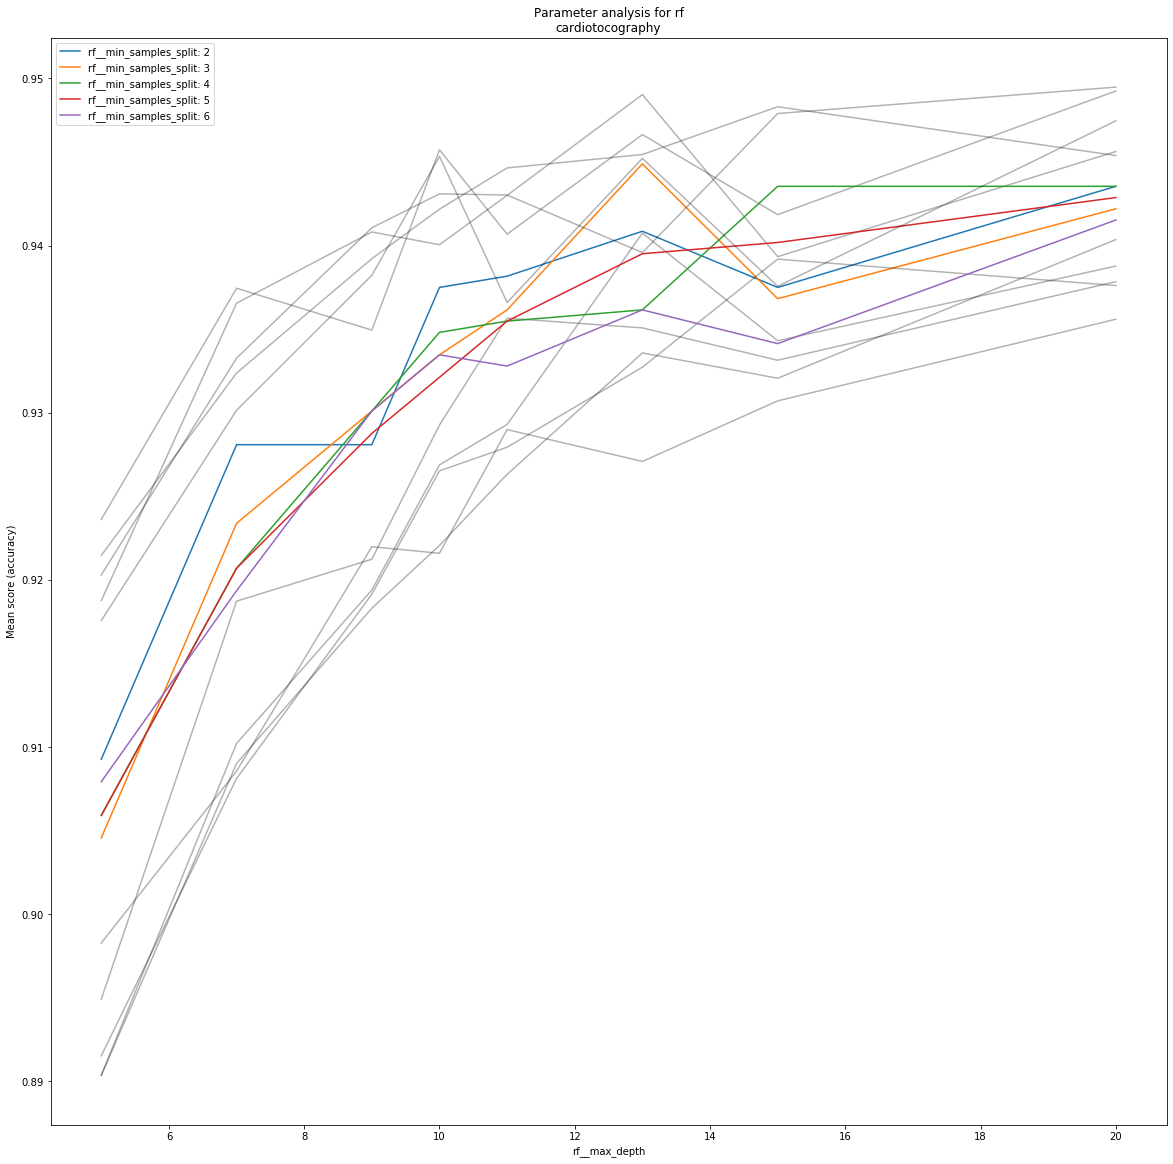

In [59]:
params_rf_base = {
    'rf__class_weight': ['balanced'],
    'rf__max_leaf_nodes': [None],
    'rf__n_estimators': [100]
}

plot_parameter_analysis(grid=grid_rf, params=params_rf, param1='rf__max_depth', 
                        param2='rf__min_samples_split', params_base=params_rf_base, 
                        method_name="rf")

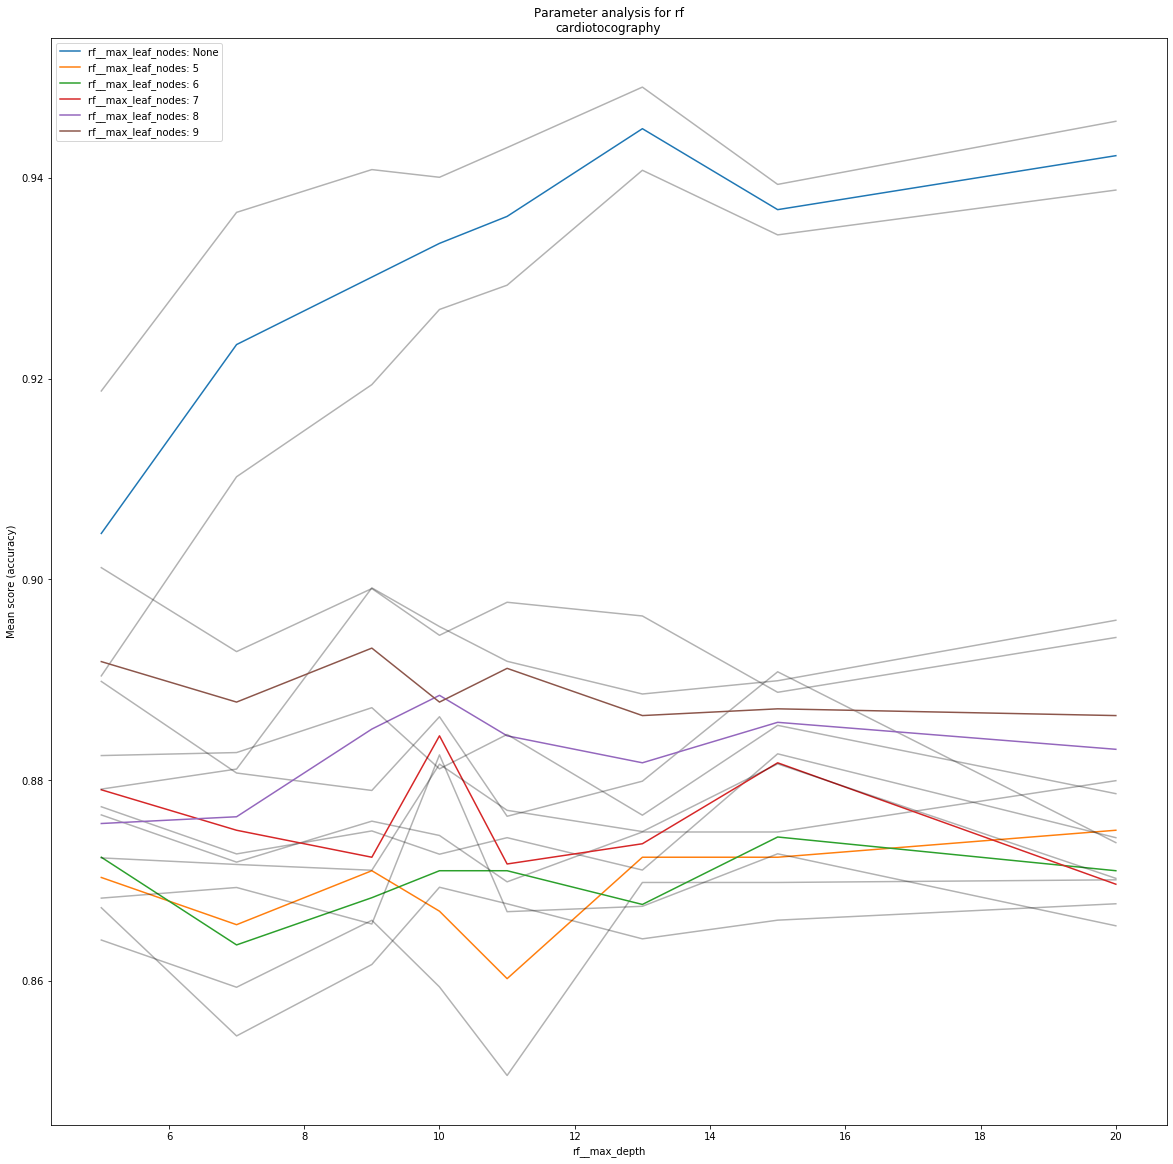

In [60]:
params_rf_base = {
    'rf__class_weight': ['balanced'],
    'rf__min_samples_split': [3],
    'rf__n_estimators': [100]
}
plot_parameter_analysis(grid=grid_rf, params=params_rf, param1='rf__max_depth', 
                        param2='rf__max_leaf_nodes', params_base=params_rf_base, 
                        method_name="rf")

In [82]:
pipe_rf.set_params(**grid_rf.best_params_)
rfecv_rf = RFECV(estimator=pipe_rf, cv=3, scoring="accuracy")

In [83]:
rfecv_rf.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('rf',
                                    RandomForestClassifier(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=13,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                    

Optimal number of features : 16
Optimal features: 
 Index(['LB', 'AC', 'FM', 'UC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Min', 'Max', 'Mode', 'Mean', 'Median', 'Variance'],
      dtype='object')


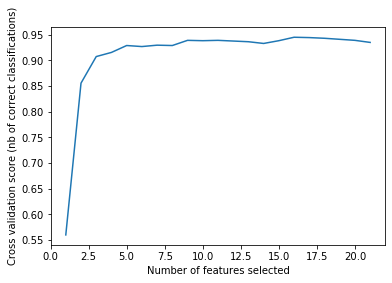

In [84]:
print("Optimal number of features : %d" % rfecv_rf.n_features_)
print("Optimal features: \n", ctg_3.columns[rfecv_rf.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_)
plt.show()

In [85]:
X_train_dropped_rf = X_train[:,rfecv_rf.get_support(indices=True)]
X_test_dropped_rf = X_test[:,rfecv_rf.get_support(indices=True)]
rfecv_rf.fit(X_train_dropped_rf, y_train)
y_pred_dropped_rf = rfecv_rf.predict(X_test_dropped_rf)

In [86]:
print(y_pred_dropped_rf.shape)
print(classification_report(y_test, y_pred_dropped_rf)) 

(638,)
              precision    recall  f1-score   support

           1       0.95      0.96      0.95       497
           2       0.77      0.72      0.74        88
           3       0.92      0.89      0.90        53

    accuracy                           0.92       638
   macro avg       0.88      0.85      0.87       638
weighted avg       0.92      0.92      0.92       638



## Creating a GradientBoostingClassifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.87 | 0.79, 0.67, 0.71 | 0.85, 0.87, 0.84 |
| - | - | - | - |

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

In [62]:
pipe_gbc = PipelineRFE([
    ('gbc', GradientBoostingClassifier())
])

In [63]:
params_gbc = {
    'gbc__learning_rate': [0.05, 0.1, 0.15, 0.3],
    'gbc__max_depth': [4, 5, 6, 7, 9],
    'gbc__max_features': ['log2'],
    'gbc__n_estimators': [50, 100]
}

In [64]:
grid_gbc = GridSearchCV(estimator=pipe_gbc,
    param_grid=params_gbc,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)


In [65]:
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   43.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=PipelineRFE(memory=None,
                                   steps=[('gbc',
                                           GradientBoostingClassifier(ccp_alpha=0.0,
                                                                      criterion='friedman_mse',
                                                                      init=None,
                                                                      learning_rate=0.1,
                                                                      loss='deviance',
                                                                      max_depth=3,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                    

In [66]:
grid_gbc.best_params_

{'gbc__learning_rate': 0.3,
 'gbc__max_depth': 6,
 'gbc__max_features': 'log2',
 'gbc__n_estimators': 100}

In [67]:
grid_gbc.score(X_test, y_test)

0.9355673436487066

In [68]:
y_pred_gbc = grid_gbc.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred_gbc)) 

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       497
           2       0.86      0.73      0.79        88
           3       0.88      0.94      0.91        53

    accuracy                           0.94       638
   macro avg       0.90      0.88      0.89       638
weighted avg       0.94      0.94      0.94       638



In [70]:
print(confusion_matrix(y_test, y_pred_gbc))
cm = confusion_matrix(y_test, y_pred_gbc)

[[484   9   4]
 [ 21  64   3]
 [  2   1  50]]


before (4, 5, 1, 2)
delete_array []
after (4, 5, 1, 2)
before (4, 5, 1, 2)
delete_array [0]
after (4, 5, 1, 1)


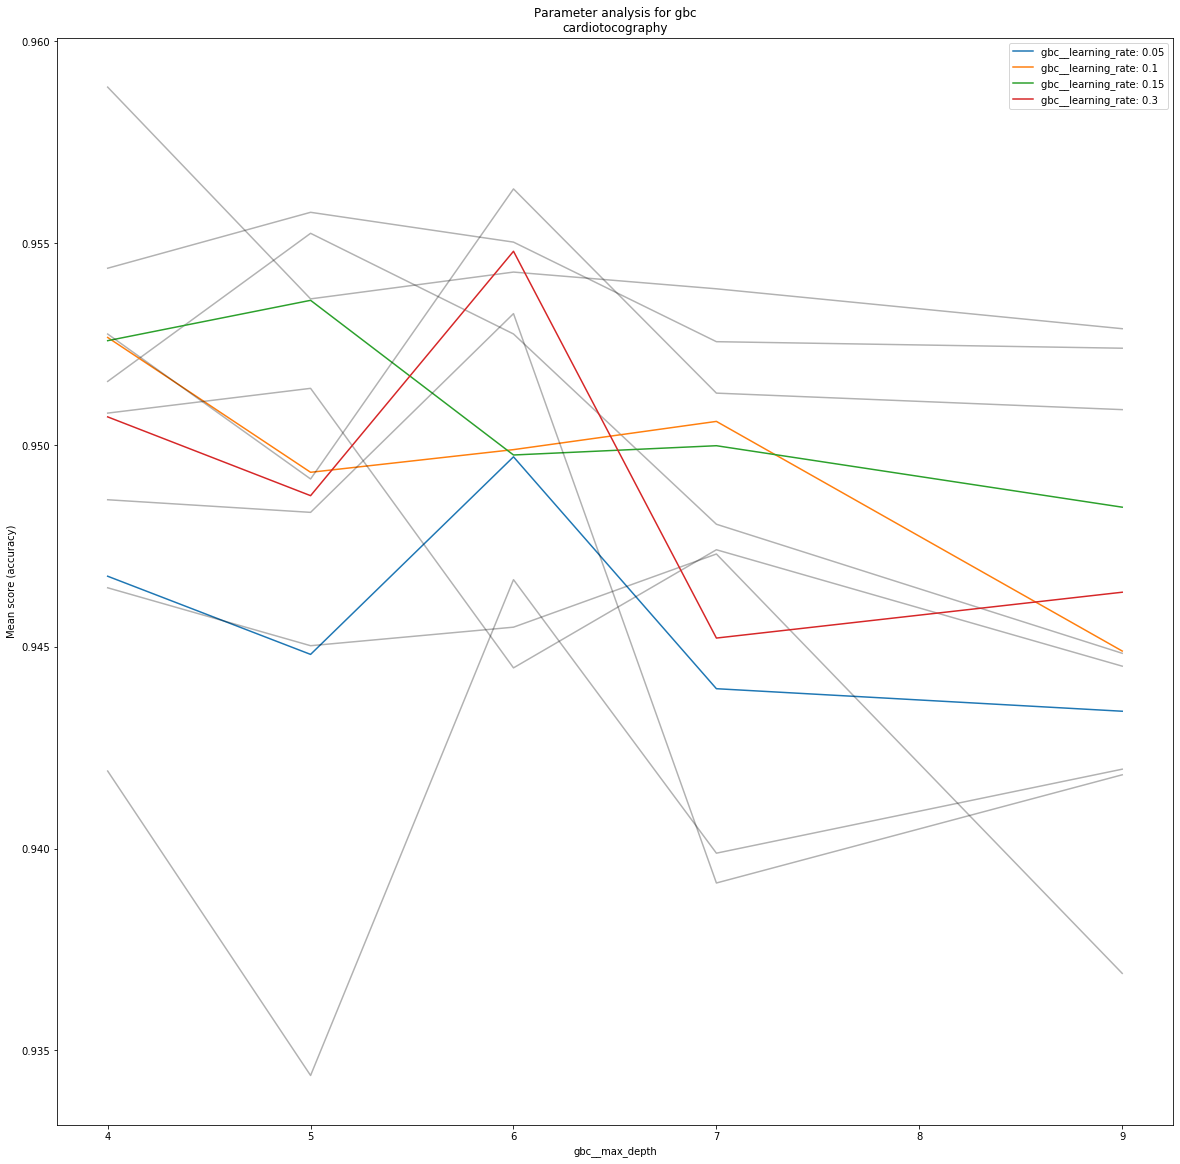

In [80]:
params_gbc_base = {
    'gbc__max_features': ['log2'],
    'gbc__n_estimators': [100]
}
plot_parameter_analysis(grid=grid_gbc, params=params_gbc, param1='gbc__max_depth', 
                        param2='gbc__learning_rate', params_base=params_gbc_base, 
                        method_name="gbc")


In [87]:
pipe_gbc.set_params(**grid_gbc.best_params_)
rfecv_gbc = RFECV(estimator=pipe_gbc, cv=3, scoring="accuracy")

In [88]:
rfecv_gbc.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('gbc',
                                    GradientBoostingClassifier(ccp_alpha=0.0,
                                                               criterion='friedman_mse',
                                                               init=None,
                                                               learning_rate=0.3,
                                                               loss='deviance',
                                                               max_depth=6,
                                                               max_features='log2',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf

Optimal number of features : 16
Optimal features: 
 Index(['LB', 'AC', 'FM', 'UC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Min', 'Max', 'Mode', 'Mean', 'Median', 'Variance'],
      dtype='object')


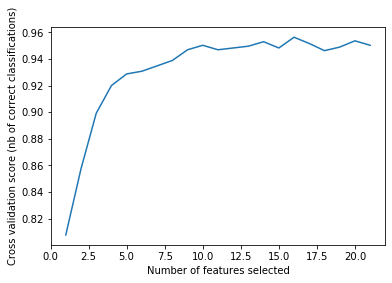

In [89]:
print("Optimal number of features : %d" % rfecv_gbc.n_features_)
print("Optimal features: \n", ctg_3.columns[rfecv_gbc.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_)
plt.show()

In [90]:
X_train_dropped_gbc = X_train[:,rfecv_gbc.get_support(indices=True)]
X_test_dropped_gbc = X_test[:,rfecv_gbc.get_support(indices=True)]
rfecv_gbc.fit(X_train_dropped_gbc, y_train)
y_pred_dropped_gbc = rfecv_gbc.predict(X_test_dropped_gbc)

In [91]:
print(y_pred_dropped_gbc.shape)
print(classification_report(y_test, y_pred_dropped_gbc)) 



(638,)
              precision    recall  f1-score   support

           1       0.95      0.98      0.97       497
           2       0.86      0.72      0.78        88
           3       0.91      0.91      0.91        53

    accuracy                           0.94       638
   macro avg       0.91      0.87      0.88       638
weighted avg       0.94      0.94      0.94       638



## Creating MLP-Classifier



In [61]:
from sklearn.neural_network import MLPClassifier

In [62]:
mdl_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, 
						batch_size=400, learning_rate='constant', learning_rate_init=0.001, 
                        max_iter=300, tol=1e-6, verbose=True)


In [63]:
mdl_mlp.fit(X_train, y_train)

Iteration 1, loss = 27.09499050
Iteration 2, loss = 17.00647114
Iteration 3, loss = 9.86390690
Iteration 4, loss = 7.14346313
Iteration 5, loss = 4.28702814
Iteration 6, loss = 2.62498887
Iteration 7, loss = 2.79845284
Iteration 8, loss = 1.66526997
Iteration 9, loss = 1.88989043
Iteration 10, loss = 1.47798598
Iteration 11, loss = 1.38314660
Iteration 12, loss = 1.15963864
Iteration 13, loss = 1.10537012
Iteration 14, loss = 0.92014362
Iteration 15, loss = 0.89653714
Iteration 16, loss = 0.84394168
Iteration 17, loss = 0.78181621
Iteration 18, loss = 0.74087382
Iteration 19, loss = 0.68425682
Iteration 20, loss = 0.63997406
Iteration 21, loss = 0.60800839
Iteration 22, loss = 0.57594403
Iteration 23, loss = 0.55127873
Iteration 24, loss = 0.52662290
Iteration 25, loss = 0.51425474
Iteration 26, loss = 0.49499667
Iteration 27, loss = 0.48224768
Iteration 28, loss = 0.46828438
Iteration 29, loss = 0.45257960
Iteration 30, loss = 0.43242838
Iteration 31, loss = 0.42329184
Iteration 32, l

MLPClassifier(activation='relu', alpha=0.0001, batch_size=400, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [64]:
mdl_mlp.score(X_test, y_test)

0.8652037617554859

In [65]:
y_pred_mdl = mdl_mlp.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_mdl)) 

              precision    recall  f1-score   support

           1       0.88      0.98      0.93       497
           2       0.64      0.28      0.39        88
           3       0.85      0.75      0.80        53

    accuracy                           0.87       638
   macro avg       0.79      0.67      0.71       638
weighted avg       0.85      0.87      0.84       638



In [67]:
print(confusion_matrix(y_test, y_pred_mdl))
cm = confusion_matrix(y_test, y_pred_mdl)



[[487   7   3]
 [ 59  25   4]
 [  6   7  40]]
